In [1]:
import os
import glob
import json
import re
import sys
sys.path.append('../')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from shapely.geometry import Polygon

from src.utils import apply_boundary_to_image

In [2]:
directory_path = "../data/images_2021/"
files_2021 = glob.glob(directory_path + "/**", recursive=True)

directory_path = "../data/images_2024/"
files_2024 = glob.glob(directory_path + "/**", recursive=True)

In [3]:
def find_files(image_id, files=[]):
    """
    Returns a dictionary with paths for boundary, images, labels, and masks for an image_id
    """
    
    image_dict = {
        "boundary": [],
        "images": {
            "nir": "",
            "rgb": []
        },
        "labels": {
            "cloud_shadow": "",
            "double_plant": "",
            "drydown": "",
            "endrow": "",
            "nutrient_deficiency": "",
            "planter_skip": "",
            "standing_water": "",
            "storm_damage": "",
            "water": "",
            "waterway": "",
            "weed_cluster": ""
        },
        "masks": []
    }
    
    # get all files
    image_files = [f for f in files if image_id in f]
    
    # boundary
    image_dict["boundary"] += [f for f in image_files if "boundar" in f]
    
    # images
    image_dict["images"]["nir"] = [f for f in image_files if re.search(r"(?:imagery|images).+(?:nir)", f)][0]
    image_dict["images"]["rgb"] += [f for f in image_files if re.search(r"(?:imagery|images).+(?:rgb|red|green|blue)", f)]
    
    # labels
    for label in image_dict["labels"].keys():
        image_dict["labels"][label] = [f for f in image_files if "labels" in f and label in f]
        try:
            image_dict["labels"][label] = image_dict["labels"][label][0]
        except:
            image_dict["labels"][label] = ""
    image_dict["labels"] = {k: v for k, v in image_dict["labels"].items() if v}
    
    # masks
    image_dict["masks"] += [f for f in image_files if "masks" in f]
    
    
    return image_dict

In [4]:
def image_to_numpy(path):
    image = Image.open(path)
    if path.endswith(".tif"):
        return np.array(image).reshape((image.size[1], image.size[0], len(image.getbands())))
    else:
        return np.array(image).reshape((*image.size, len(image.getbands())))

In [5]:
def display_image(image_dict):
    
    images_list = []
    image_names = []
    
    # rgb images
    if len(image_dict["images"]["rgb"]) == 1:
        rgb_image = image_to_numpy(image_dict["images"]["rgb"][0])
        images_list.append(rgb_image)
        image_names.append("RGB Image")
    elif len(image_dict["images"]["rgb"]) == 3:
        red_image = image_to_numpy([f for f in image_dict["images"]["rgb"] if "red" in f][0])
        green_image = image_to_numpy([f for f in image_dict["images"]["rgb"] if "green" in f][0])
        blue_image = image_to_numpy([f for f in image_dict["images"]["rgb"] if "blue" in f][0])
        rgb_image = np.stack((red_image[:,:,0], green_image[:,:,0], blue_image[:,:,0]), axis=-1)
        rgb_image = cv2.normalize(rgb_image, rgb_image, 0, 255, cv2.NORM_MINMAX).astype(int)
        images_list.append(rgb_image)
        image_names.append("RGB Image")
        images_list.append(red_image)
        image_names.append("Red Image")
        images_list.append(green_image)
        image_names.append("Green Image")
        images_list.append(blue_image)
        image_names.append("Blue Image")
        
    
    # nir image
    nir_image = image_to_numpy(image_dict["images"]["nir"])
    images_list.append(nir_image)
    image_names.append("NIR Image")
        
    # boundary images
    for b in range(len(image_dict["boundary"])):
        boundary_path = image_dict["boundary"][b]
        if boundary_path.endswith(".json"):
            with open(boundary_path) as f:
                mask, rgb_masked_image = apply_boundary_to_image(boundary_path, rgb_image)
            images_list.append(mask[..., np.newaxis])
            image_names.append("Boundary")
            # rgb_masked_image = apply_boundary_to_image(boundary_path, rgb_image)
            images_list.append(rgb_masked_image)
            image_names.append("RGB with Boundary")
        else:
            boundary_image = image_to_numpy(image_dict["boundary"][b])
            images_list.append(boundary_image)
            image_names.append("Boundary %s" % str(b+1))
        
    # mask images
    for m in range(len(image_dict["masks"])):
        mask_image = image_to_numpy(image_dict["masks"][m])
        images_list.append(mask_image)
        image_names.append("Mask %s" % str(b+1))
        
    # label images
    labels_to_add_to_overlay = {}
    for l in image_dict["labels"].keys():
        label_path = image_dict["labels"][l]
        if label_path:
            label_image = image_to_numpy(image_dict["labels"][l])
            images_list.append(label_image)
            image_names.append("Label %s" % l)
            if np.max(label_image) > 0:
                labels_to_add_to_overlay[l] = label_image
        
    # overlay image
    if len(labels_to_add_to_overlay.keys()) > 0:
        overlay_image = rgb_image.astype(np.float64)
        overlay_colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]]
        handles = []
        for i, l in enumerate(labels_to_add_to_overlay.keys()):
            overlay_image += 0.5 * labels_to_add_to_overlay[l] * overlay_colors[i]
            handles.append(plt.Line2D([], [], color=overlay_colors[i], label=l))
        overlay_image = np.clip(overlay_image.astype(int), 0, 255)
        images_list.insert(0, overlay_image)
        image_names.insert(0, "Overlay Image")
    
    # plot
    n = len(images_list)
    ncols = 5
    nrows = max((n-1) // ncols + 1, 2)
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))
    for i in range(nrows*ncols):
        if i < len(images_list):
            if images_list[i].shape[2] == 3:
                axes[i//ncols][i%ncols].imshow(images_list[i])
            elif images_list[i].shape[2] == 1:
                axes[i//ncols][i%ncols].imshow(images_list[i][:,:,0], cmap="gray")
            axes[i//ncols][i%ncols].set_title(image_names[i])
        axes[i//ncols][i%ncols].axis("off")
    if len(labels_to_add_to_overlay.keys()) > 0:
        axes[0][0].legend(handles=handles, loc="upper left")
    
    plt.show()

{'boundary': ['../data/images_2021\\train\\boundaries\\1AD76MIZN_1683-7882-2195-8394.png'], 'images': {'nir': '../data/images_2021\\train\\images\\nir\\1AD76MIZN_1683-7882-2195-8394.jpg', 'rgb': ['../data/images_2021\\train\\images\\rgb\\1AD76MIZN_1683-7882-2195-8394.jpg']}, 'labels': {'double_plant': '../data/images_2021\\train\\labels\\double_plant\\1AD76MIZN_1683-7882-2195-8394.png', 'drydown': '../data/images_2021\\train\\labels\\drydown\\1AD76MIZN_1683-7882-2195-8394.png', 'endrow': '../data/images_2021\\train\\labels\\endrow\\1AD76MIZN_1683-7882-2195-8394.png', 'nutrient_deficiency': '../data/images_2021\\train\\labels\\nutrient_deficiency\\1AD76MIZN_1683-7882-2195-8394.png', 'planter_skip': '../data/images_2021\\train\\labels\\planter_skip\\1AD76MIZN_1683-7882-2195-8394.png', 'storm_damage': '../data/images_2021\\train\\labels\\storm_damage\\1AD76MIZN_1683-7882-2195-8394.png', 'water': '../data/images_2021\\train\\labels\\water\\1AD76MIZN_1683-7882-2195-8394.png', 'waterway': '.

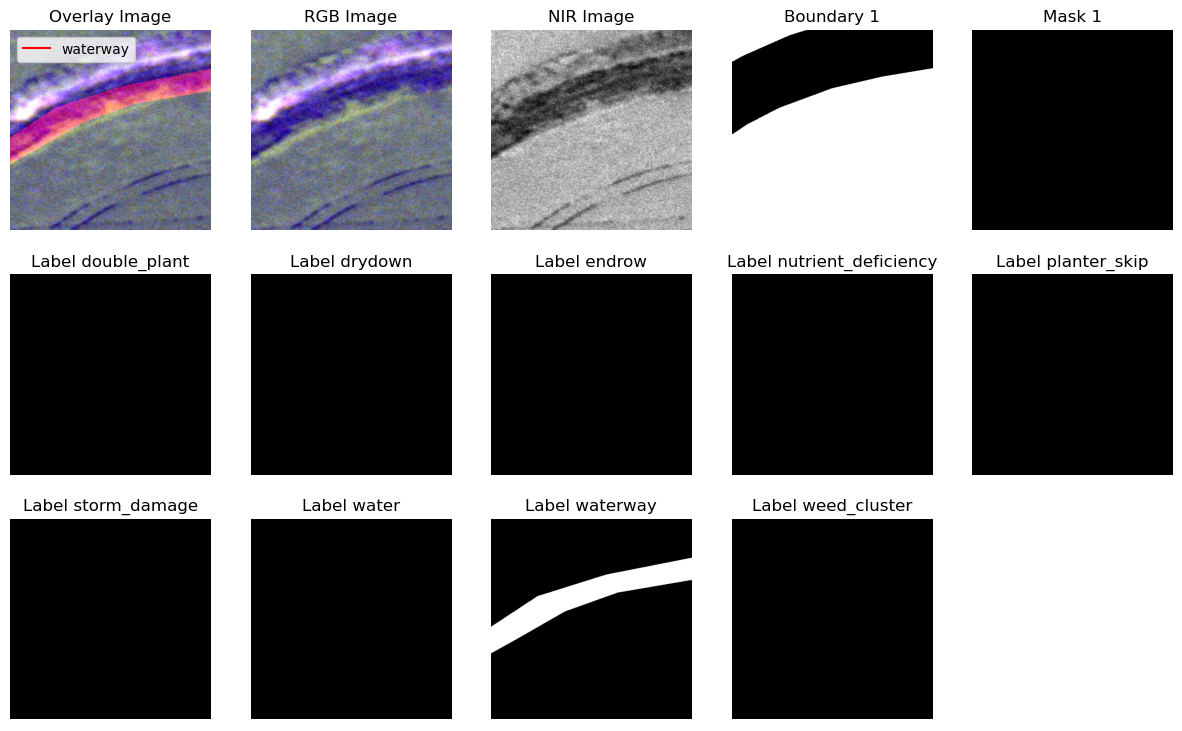

In [6]:
image_id = "1AD76MIZN_1683-7882-2195-8394"
image_dict = find_files(image_id, files_2021)
print(image_dict)
display_image(image_dict)

{'boundary': ['../data/images_2024\\1BGXDBEAZ Wu Jing\\boundary.json'], 'images': {'nir': '../data/images_2024\\1BGXDBEAZ Wu Jing\\imagery\\nir.tif', 'rgb': ['../data/images_2024\\1BGXDBEAZ Wu Jing\\imagery\\blue.tif', '../data/images_2024\\1BGXDBEAZ Wu Jing\\imagery\\green.tif', '../data/images_2024\\1BGXDBEAZ Wu Jing\\imagery\\red.tif']}, 'labels': {}, 'masks': []}


C:\Users\Francis\miniconda3\envs\cs7643-project\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (91898694 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


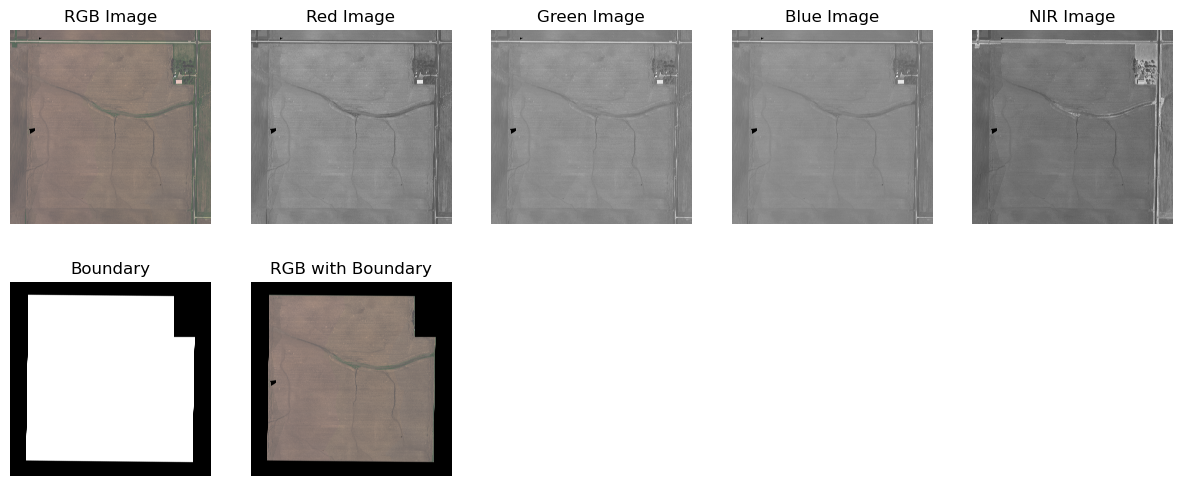

In [7]:
image_id = "1BGXDBEAZ"
image_dict = find_files(image_id, files_2024)
print(image_dict)
display_image(image_dict)